## 2 - Design of predictive model

### Importing librairies

In [220]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot  as plt
import numpy as np
import feather
import seaborn as sns
from datetime import datetime
import pickle
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import warnings; warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200 
pd.set_option('display.float_format', lambda x: '%.3f' % x) #display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

Importing the data

In [221]:
file_path = '2016_clean.csv'
df = pd.read_csv(file_path, low_memory=False)
df = df.drop('Unnamed: 0', axis = 1)
df.shape

(5440148, 10)

Adding columns to the data

In [222]:
df['DAY_OF_WEEK'] = df['DAY'].apply(lambda x: round((x-4)%7)+1)

In [223]:
df.shape

(5440148, 11)

In [224]:
def myround(x, base):
    return int(base * round(float(x)/base))

df['Heure départ'] = df['CRS_DEP_TIME'].apply(lambda x:myround(x ,5))
df['Heure arrivée'] = df['CRS_ARR_TIME'].apply(lambda x:myround(x ,5))


In [225]:
df['Temps de vol'] = df['CRS_ELAPSED_TIME'].apply(lambda x:myround(x ,10))

In [226]:
df['Jour'] = df['DAY']
df['Jour semaine'] = df['DAY_OF_WEEK']
df['Airline']=df['CARRIER']
df['Code Avion'] = df['TAIL_NUM']
df['Aeroport départ'] = df['ORIGIN_AIRPORT_ID']
df['Aeroport arrivée'] =df['DEST_AIRPORT_ID']

In [227]:
df.columns

Index(['DELAY', 'DAY', 'WEEK', 'CARRIER', 'TAIL_NUM', 'ORIGIN_AIRPORT_ID',
       'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
       'DAY_OF_WEEK', 'Heure départ', 'Heure arrivée', 'Temps de vol', 'Jour',
       'Jour semaine', 'Airline', 'Code Avion', 'Aeroport départ',
       'Aeroport arrivée'],
      dtype='object')

### Outliers

In [228]:
ten_min_delay_count = df[df['DELAY'] >5].shape[0]

quantile_99 = df[df['DELAY'] >5]['DELAY'].quantile(0.99)
outlier_delay_count =df[df['DELAY'] >quantile_99].shape[0]

print( 'Out of',ten_min_delay_count, 'flights delayed of more than 5 min' )
print( '99% are under',quantile_99,'min' )
print( 'Which leaves 1% of very large delays (outliers) : ',outlier_delay_count,'flights' )
print( 'Lowering those delays to',quantile_99,'to not impact mean values too much')

df.loc[df['DELAY'] >quantile_99, 'DELAY'] = quantile_99


Out of 1413917 flights delayed of more than 5 min
99% are under 290.0 min
Which leaves 1% of very large delays (outliers) :  14119 flights
Lowering those delays to 290.0 to not impact mean values too much


In [229]:
def fill_feature_with_mean(df, feature_name) :
    print('Filling null',feature_name,'with mean:',round(df[feature_name].mean(),2))
    df[feature_name] = df[feature_name].fillna(round(df[feature_name].mean(),2))

### Separate data in 2 sets

In [230]:
msk = np.random.rand(len(df)) < 0.7
train_set = df[msk]
test_set = df[~msk]
print('Train set has',train_set.shape[0],'rows')
print('Test set has',test_set.shape[0],'rows')

Train set has 3806996 rows
Test set has 1633152 rows


### Testing effects of polynomial transformations
Ordering first by mean delay on our train set
Then checking poly transformation scoring effect

In [231]:
#given X and y single features DFs
def display_poly(X,y):
    plt.rcParams["figure.figsize"] = (15,8)
    col = X.columns[0]
    x_range = np.linspace(X.min().values[0], X.max().values[0], X.nunique().values[0])
    
    y_true= X.join(y).groupby(col).mean().values.flatten()

    X = X.values.flatten()
    y = y.values.flatten()

    # create matrix versions of these arrays
    np_x = X[:, np.newaxis]
    np_x_range = x_range[:, np.newaxis]
    colors = ['green', 'orange', 'red', 'gold', 'purple', 'black']
    plt.plot(x_range, y_true, color='cornflowerblue', linewidth=3,
             label="ground truth")

    for count, degree in enumerate([0,3,6,9]):
        if degree ==0:
            model = make_pipeline(Ridge())
        else:   
            model = make_pipeline(PolynomialFeatures(degree), Ridge())
        silent =  model.fit(np_x, y)
        y_plot = model.predict(np_x_range)
        r2_score = round(model.score(np_x, y)*10000)/10000
        silent = plt.plot(x_range, y_plot, color=colors[count], linewidth=2,  linestyle = '--', alpha = 0.8,
                 label="degree {} (score:{})".format(degree, r2_score))

        silent = plt.legend(loc='bottom right')
        silent = plt.title('Retard moyen par '+col)
        silent = plt.ylabel('Retard moyen (minutes)')
        silent = plt.xlabel(col)

    plt.show()

In [232]:
X_cols=pd.DataFrame(
    columns=['original_name','reorder','nb_poly_features', 'poly_score']
    , data=[
   ['Jour',True, 9 , 0.0299            ]
    ,['Jour semaine',True, 1, 0.008]
    ,['Airline',True,3,0.005            ]
    ,['Code Avion',True,3,0.01 ]            
    ,['Temps de vol',True,3, 0.001]
    ,['Aeroport départ',True,3,0.0047      ]
    ,['Aeroport arrivée',True,3,0.0056        ]
    ,['Heure départ',False,3,0.0129          ]
    ,['Heure arrivée',False,3,0.0128          ]
     ])

X_cols['new_name']=X_cols['original_name']
X_cols

,original_name,reorder,nb_poly_features,poly_score,new_name
0,Jour,True,9,0.030,Jour
1,Jour semaine,True,1,0.008,Jour semaine
2,Airline,True,3,0.005,Airline
3,Code Avion,True,3,0.010,Code Avion
4,Temps de vol,True,3,0.001,Temps de vol
5,Aeroport départ,True,3,0.005,Aeroport départ
6,Aeroport arrivée,True,3,0.006,Aeroport arrivée
7,Heure départ,False,3,0.013,Heure départ
8,Heure arrivée,False,3,0.013,Heure arrivée


Filling null jour ordonné with mean: 186.06


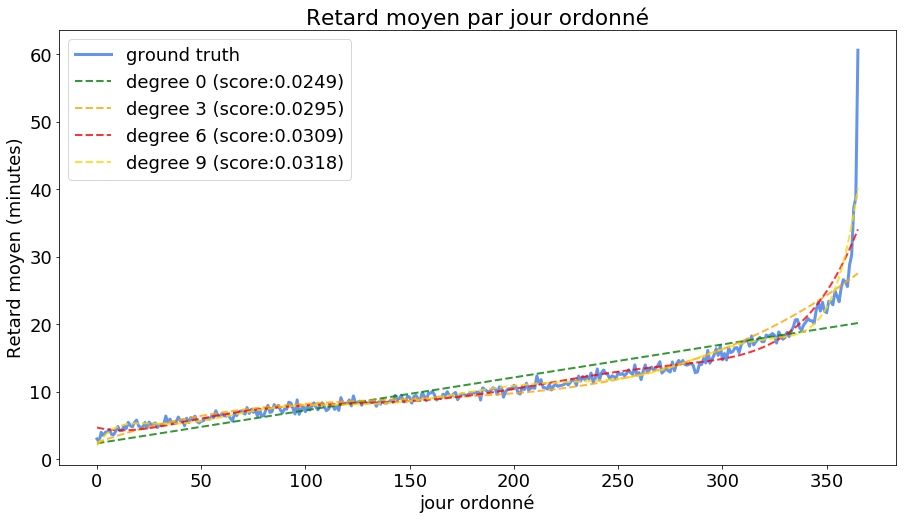

Filling null jour semaine ordonné with mean: 3.09


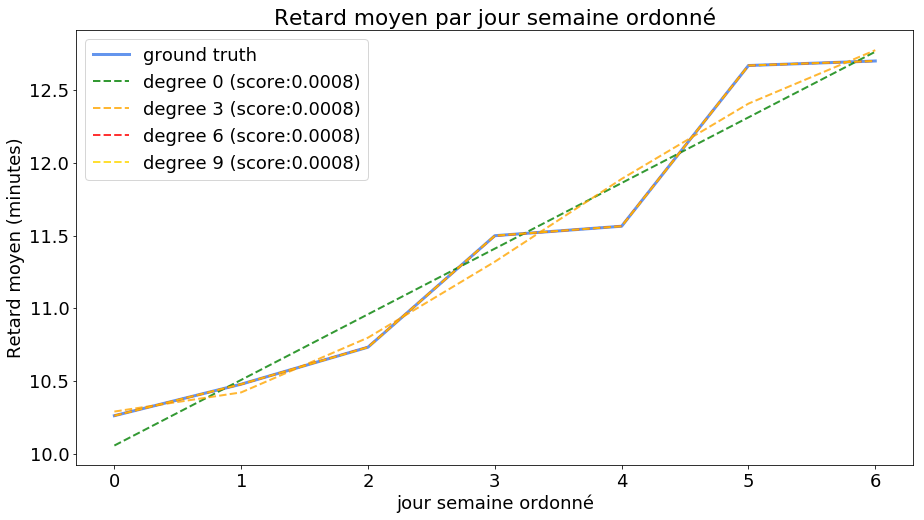

Filling null airline ordonné with mean: 4.53


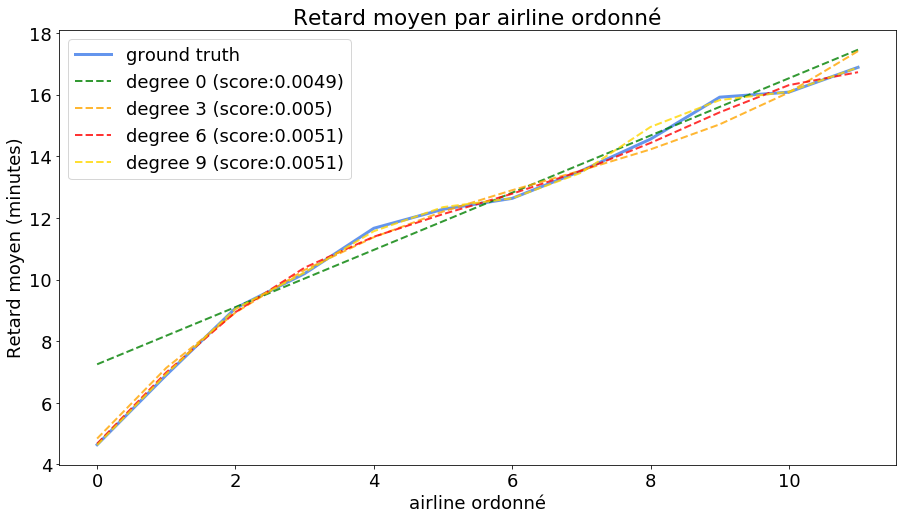

Filling null code avion ordonné with mean: 2390.59


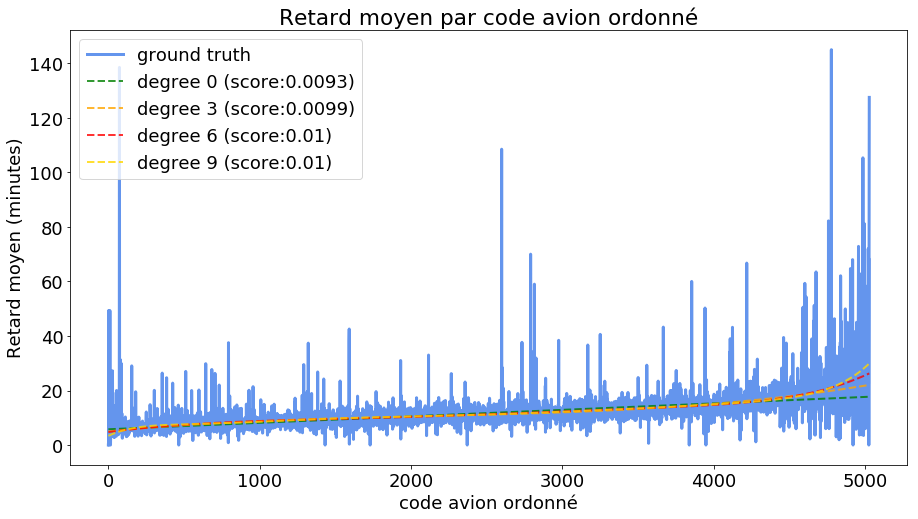

Filling null temps de vol ordonné with mean: 32.8


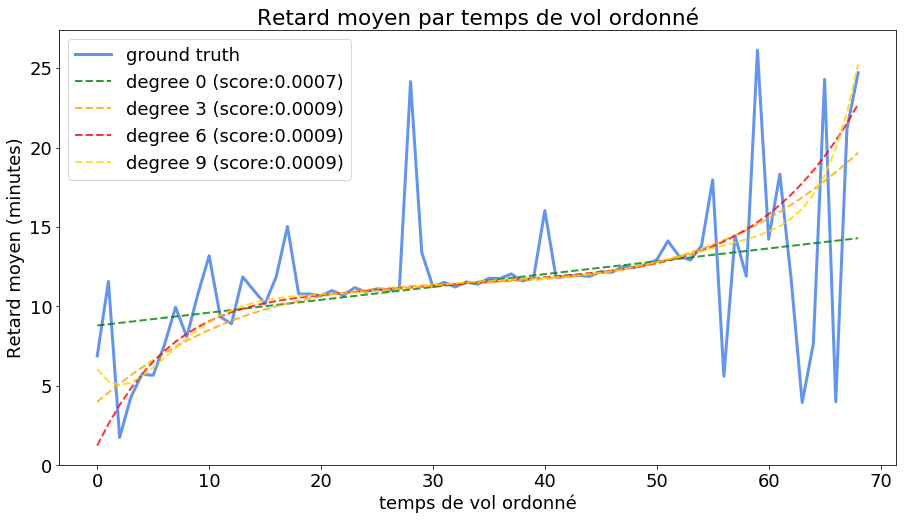

Filling null aeroport départ ordonné with mean: 162.9


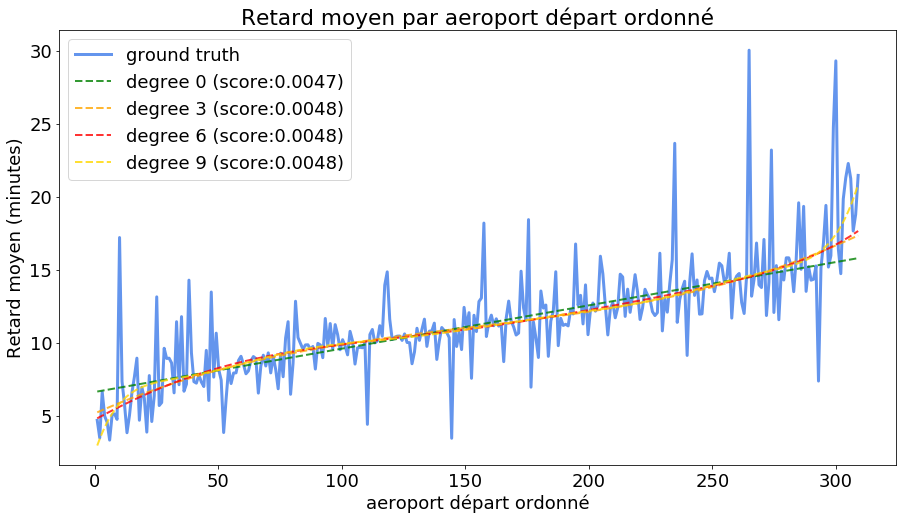

Filling null aeroport arrivée ordonné with mean: 173.88


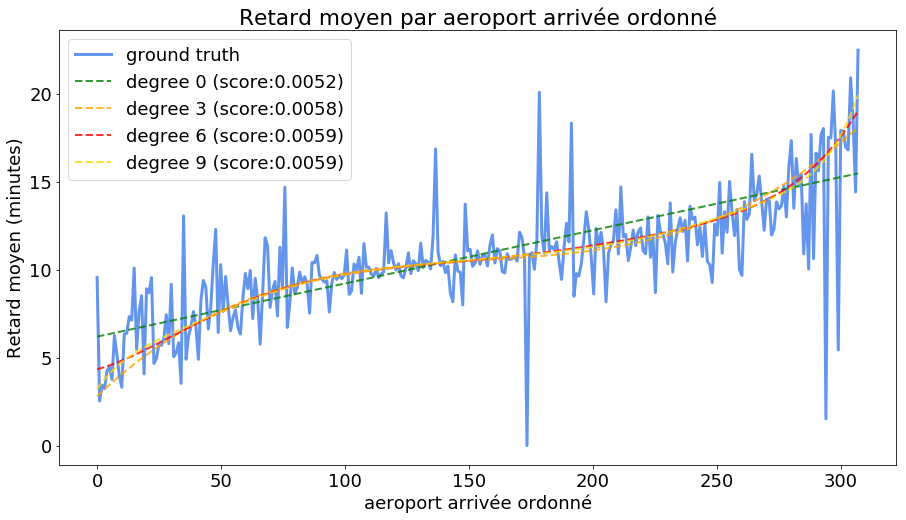

Filling null Heure départ with mean: 1330.19


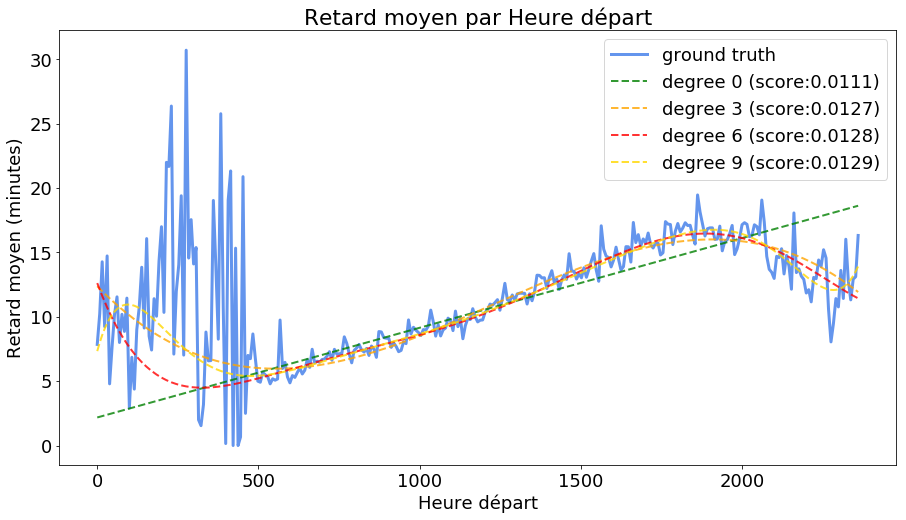

Filling null Heure arrivée with mean: 1490.54


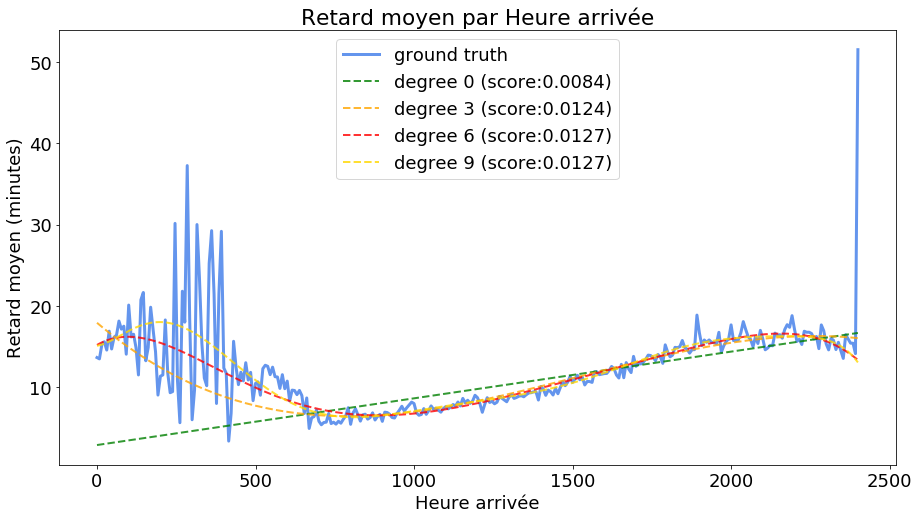

In [233]:
y_col = 'DELAY'
for index, row in X_cols.iterrows():
    col = row['original_name']
    if row['reorder'] == True:
        X_cols.loc[index, 'new_name'] = col_new_name = col.lower()+' ordonné'
        if col_new_name not in test_set.columns:
            col_ordered =train_set[[col,y_col]].groupby(col).mean().sort_values(y_col).reset_index().reset_index().set_index(col).rename({'index':col_new_name}, axis=1)
            test_set = test_set.join(col_ordered.drop(y_col , axis =1), on=col)
    else:
        X_cols.loc[index, 'new_name'] = col_new_name = col
        
    fill_feature_with_mean(test_set, col_new_name)
    
    X_ = test_set[[col_new_name]]
    y_ = test_set[[y_col]]
    display_poly(X_, y_)
    
    

In [234]:
X = test_set.loc[:, X_cols['new_name']]
y = test_set['DELAY']
X.shape
y.shape

(1633152, 9)

(1633152,)

In [235]:
X.columns

Index(['jour ordonné', 'jour semaine ordonné', 'airline ordonné',
       'code avion ordonné', 'temps de vol ordonné', 'aeroport départ ordonné',
       'aeroport arrivée ordonné', 'Heure départ', 'Heure arrivée'],
      dtype='object')

### Displaying correlated features before applying poly transformation

Text(0.5,1,'Tableau de Correlation')

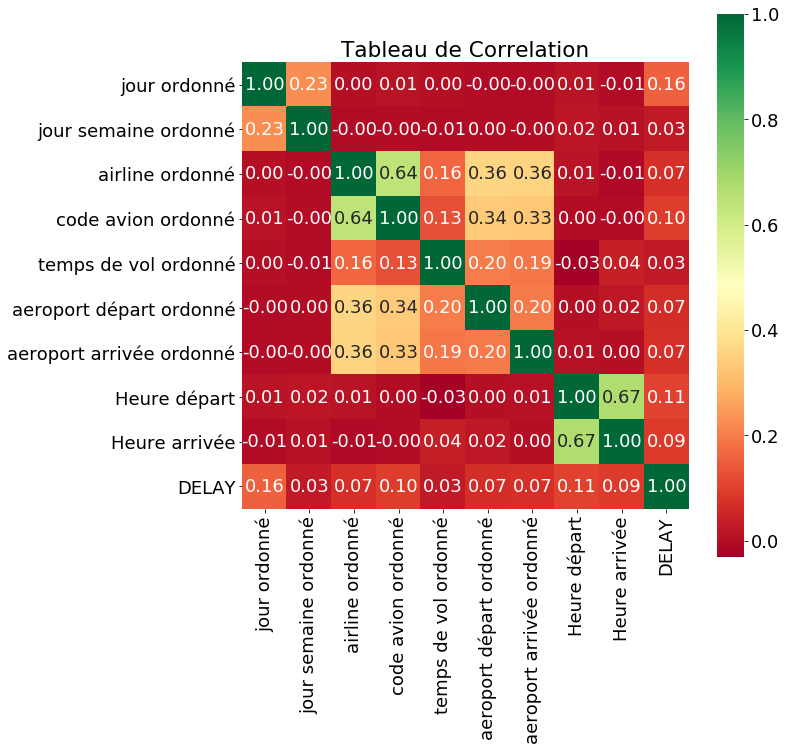

In [236]:
plt.rcParams["figure.figsize"] = (10,10)
xy = pd.concat([X, y], axis=1, join='inner')
fig = sns.heatmap(xy.corr(), annot = True,fmt = ".2f",square=True, cmap='RdYlGn')
plt.title('Tableau de Correlation')

## Polynomial features preprocess

In [237]:
# Applying poly transformation on our selected features
for index, row in X_cols.iterrows():
    col = row['original_name']
    nb_poly_features = row['nb_poly_features']
    col_new_name = row['new_name']
    
    
    df_col_ordered =  pd.DataFrame(test_set[col_new_name].unique(), columns=[col_new_name]).sort_values(col_new_name)
        
   # df_col_ordered
    if nb_poly_features>0:
        poly = PolynomialFeatures(nb_poly_features, include_bias  =False)
        poly_transfo = poly.fit_transform(df_col_ordered)
        df_poly = pd.DataFrame(poly_transfo, index=df_col_ordered[col_new_name].values).add_prefix(col.lower()+'_poly_')

        X = X.join(df_poly , on =col_new_name, how='left').drop(col_new_name, axis=1)
        print(col,'processed.',X.shape)


Jour processed. (1633152, 17)
Jour semaine processed. (1633152, 17)
Airline processed. (1633152, 19)
Code Avion processed. (1633152, 21)
Temps de vol processed. (1633152, 23)
Aeroport départ processed. (1633152, 25)
Aeroport arrivée processed. (1633152, 27)
Heure départ processed. (1633152, 29)
Heure arrivée processed. (1633152, 31)


In [238]:
X.describe()

,jour_poly_0,jour_poly_1,jour_poly_2,jour_poly_3,jour_poly_4,jour_poly_5,jour_poly_6,jour_poly_7,jour_poly_8,jour semaine_poly_0,airline_poly_0,airline_poly_1,airline_poly_2,code avion_poly_0,code avion_poly_1,code avion_poly_2,temps de vol_poly_0,temps de vol_poly_1,temps de vol_poly_2,aeroport départ_poly_0,aeroport départ_poly_1,aeroport départ_poly_2,aeroport arrivée_poly_0,aeroport arrivée_poly_1,aeroport arrivée_poly_2,heure départ_poly_0,heure départ_poly_1,heure départ_poly_2,heure arrivée_poly_0,heure arrivée_poly_1,heure arrivée_poly_2
count,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000,1633152.000
mean,186.059,45589.153,12533560.199,3671046292.967,1119201893258.323,350792561372460.625,112204329319653456.000,36451731045348601856.000,11988421701899112153088.000,3.091,4.527,26.432,183.982,2390.585,7450764.835,26172952367.245,32.803,1195.761,47292.596,162.895,32176.192,7119007.447,173.885,36229.683,8449395.512,1330.188,2008969.878,3317088452.858,1490.544,2488044.163,4459704104.562
std,104.743,39908.350,13917706.302,4793241515.746,1652167088343.632,571622438497063.125,198599237912217760.000,69270775887456788480.000,24246476220761034981376.000,1.981,2.437,27.351,280.001,1317.524,6554368.169,29763529640.562,10.942,750.549,42477.353,75.109,25586.739,7516162.960,77.419,28233.783,8678453.846,489.459,1338493.316,3044847875.457,516.066,1490246.261,3634153274.874
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,96.000,9216.000,884736.000,84934656.000,8153726976.000,782757789696.000,75144747810816.000,7213895789838336.000,692533995824480256.000,1.000,3.000,9.000,27.000,1294.000,1674436.000,2166720184.000,24.000,576.000,13824.000,100.000,10000.000,1000000.000,109.000,11881.000,1295029.000,915.000,837225.000,766060875.000,1105.000,1221025.000,1349232625.000
50%,187.000,34969.000,6539203.000,1222830961.000,228669389707.000,42761175875209.000,7996339888664083.000,1495315559180183552.000,279624009566694309888.000,3.000,4.000,16.000,64.000,2353.000,5536609.000,13027640977.000,30.000,900.000,27000.000,161.000,25921.000,4173281.000,167.000,27889.000,4657463.000,1325.000,1755625.000,2326203125.000,1520.000,2310400.000,3511808000.000
75%,277.000,76729.000,21253933.000,5887339441.000,1630793025157.000,451729667968489.000,125129118027271456.000,34660765693554192384.000,9601032097114510852096.000,5.000,6.000,36.000,216.000,3514.000,12348196.000,43391560744.000,42.000,1764.000,74088.000,249.000,62001.000,15438249.000,253.000,64009.000,16194277.000,1735.000,3010225.000,5222740375.000,1920.000,3686400.000,7077888000.000
max,365.000,133225.000,48627125.000,17748900625.000,6478348728125.000,2364597285765625.000,863078009304453120.000,315023473396125401088.000,114983567789585766285312.000,6.000,11.000,121.000,1331.000,5029.000,25290841.000,127187639389.000,68.000,4624.000,314432.000,309.000,95481.000,29503629.000,307.000,94249.000,28934443.000,2360.000,5569600.000,13144256000.000,2400.000,5760000.000,13824000000.000


## Prediction models

## Split data

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Linear regression

In [242]:
linear = LinearRegression()
cv_scores = cross_val_score(linear, X, y, cv =5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


linear.fit(X_train, y_train)

y_true, y_pred = y_test, linear.predict(X_test)

print("R squared: {}".format(r2_score(y_true, y_pred)))
print("Mean absolute value : {}".format(mean_absolute_error(y_true, y_pred)))
print("rmse : {}".format(math.sqrt(mean_squared_error(y_true, y_pred))))



Average 5-Fold CV Score: 0.04654322530702946


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

R squared: 0.054233717186997765
Mean absolute value : 15.967321507539156
rmse : 31.387535369347034


### Hyper param display functions

In [246]:
def display_plot(cv_scores, cv_scores_std, alpha_space):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [247]:
def hyper_param(model, X, y):
    alpha_space = np.logspace(-16, 0, 20)
    scores = []
    scores_std = []
    model.normalize = True

    # Compute scores over range of alphas
    for alpha in alpha_space:
        model.alpha = alpha

        # k folds
        cv_scores = cross_val_score(model, X, y, cv =3)

        scores.append(np.mean(cv_scores))
        scores_std.append(np.std(cv_scores))
    
    max_score =  max(scores)
    returned_alpha = alpha_space[scores.index(max_score)]
    print ('Highest score is', max_score, 'alpha :', returned_alpha)
    
    plt.rcParams["figure.figsize"] = (10,4)
    display_plot(scores, scores_std, alpha_space)
    return returned_alpha

## Lasso

In [249]:
lasso = Lasso(normalize = True)
lasso.alpha = hyper_param(Lasso(), X_train, y_train)

In [252]:
#parameters = {'alpha': np.logspace(-15, 0, 20)}
#gm_cv = GridSearchCV(lasso,param_grid=parameters)
#gm_cv.fit(X_train,y_train)

In [ ]:
plt.rcParams["figure.figsize"] = (10,4)
lasso.fit(X_train,y_train)
lasso_coef = lasso.coef_
print(lasso_coef , 'lasso coeff')

silent = plt.bar(range(len(X.columns)), lasso_coef)
silent = plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
silent = plt.title('Selecting best alpha')
silent = plt.ylabel('Lasso Coeff')
silent = plt.title('Lasso coefficients')


silent =plt.show()

cv_scores = cross_val_score(lasso,  X, y, cv =5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

y_true, y_pred = y_test, lasso.predict(X_test)

print("Lasso R squared: {}".format(r2_score(y_true, y_pred)))
print("Mean absolute value : {}".format(mean_absolute_error(y_true, y_pred)))
print("rmse : {}".format(math.sqrt(mean_squared_error(y_true, y_pred))))



## Ridge Reg (chosen model)

Highest score is 0.05816272655978808 alpha : 4.8329302385717525e-15


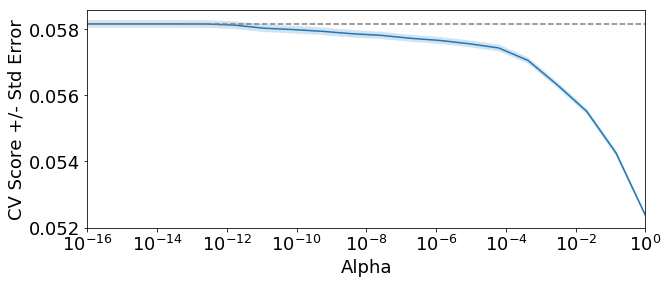

In [253]:
ridge = Ridge()
ridge.alpha = hyper_param(Ridge(), X_train, y_train)

In [254]:
ridge.fit(X_train, y_train)
y_true, y_pred = y_test, ridge.predict(X_test)

print("r2_score : {}".format(r2_score(y_true, y_pred)))
print("Mean absolute value : {}".format(mean_absolute_error(y_true, y_pred)))
print("rmse : {}".format(math.sqrt(mean_squared_error(y_true, y_pred))))

Ridge(alpha=4.8329302385717525e-15, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

r2_score : 0.05817633486917928
Mean absolute value : 16.00065923855087
rmse : 31.32204440612369


In [255]:
cv_scores = cross_val_score(ridge,  X, y, cv =5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.04969051238413158


In [256]:
results = test_set.loc[X_test.index]
results['y_pred'] = y_pred
results['y_true'] = results['DELAY']
results.head(5)

,DELAY,DAY,WEEK,CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DAY_OF_WEEK,Heure départ,Heure arrivée,Temps de vol,Jour,Jour semaine,Airline,Code Avion,Aeroport départ,Aeroport arrivée,jour ordonné,jour semaine ordonné,airline ordonné,code avion ordonné,temps de vol ordonné,aeroport départ ordonné,aeroport arrivée ordonné,y_pred,y_true
369758,2.000,13,14,WN,N8641B,13342.000,15304.000,715.000,1110.000,175.000,3,715,1110,180,13,3,WN,N8641B,13342.000,15304.000,158,1,3,329.000,50,113,208.000,-0.697,2.000
3985177,0.000,260,259,DL,N906AT,10397.000,13230.000,954.000,1143.000,109.000,5,955,1145,110,260,5,DL,N906AT,10397.000,13230.000,84,6,2,239.000,26,87,218.000,-1.215,0.000
4153626,0.000,277,280,EV,N14977,10469.000,13930.000,635.000,638.000,63.000,1,635,640,60,277,1,EV,N14977,10469.000,13930.000,53,4,7,2604.000,20,211,268.000,2.084,0.000
131256,110.000,21,21,OO,N955SW,13342.000,13930.000,1626.000,1725.000,59.000,4,1625,1725,60,21,4,OO,N955SW,13342.000,13930.000,188,5,4,1969.000,20,113,268.000,13.315,110.000
2580899,39.000,173,175,AA,N669AW,14100.000,14747.000,735.000,1027.000,352.000,2,735,1025,350,173,2,AA,N669AW,14100.000,14747.000,314,2,6,1636.000,47,200,99.000,10.235,39.000


In [257]:
def compare_result_plot(results, col_name):
    plt.rcParams["figure.figsize"] = (12,6)
    X= results[col_name]
    x_range = np.linspace(X.min(), X.max(), X.nunique())
     
    y_true= results[['y_true', col_name]].groupby(col_name).mean().values
    y_pred= results[['y_pred', col_name]].groupby(col_name).mean().values

    X = X.values
    
    # create matrix versions of these arrays
    np_x = X[:, np.newaxis]
    np_x_range = x_range[:, np.newaxis]

    plt.plot(x_range, y_true, color='cornflowerblue', linewidth=3, alpha=0.5,
        label="true mean")
    plt.plot(x_range, y_pred, color='red', linewidth=3, linestyle = '-', alpha=0.5,
         label="pred mean")

    silent = plt.legend(loc='bottom right')
    silent = plt.title('Retard moyen par '+col_name)
    silent = plt.ylabel('Retard moyen (minutes)')
    silent = plt.xlabel(col_name)
        
    plt.show()

In [258]:
X_cols

,original_name,reorder,nb_poly_features,poly_score,new_name
0,Jour,True,9,0.030,jour ordonné
1,Jour semaine,True,1,0.008,jour semaine ordonné
2,Airline,True,3,0.005,airline ordonné
3,Code Avion,True,3,0.010,code avion ordonné
4,Temps de vol,True,3,0.001,temps de vol ordonné
5,Aeroport départ,True,3,0.005,aeroport départ ordonné
6,Aeroport arrivée,True,3,0.006,aeroport arrivée ordonné
7,Heure départ,False,3,0.013,Heure départ
8,Heure arrivée,False,3,0.013,Heure arrivée


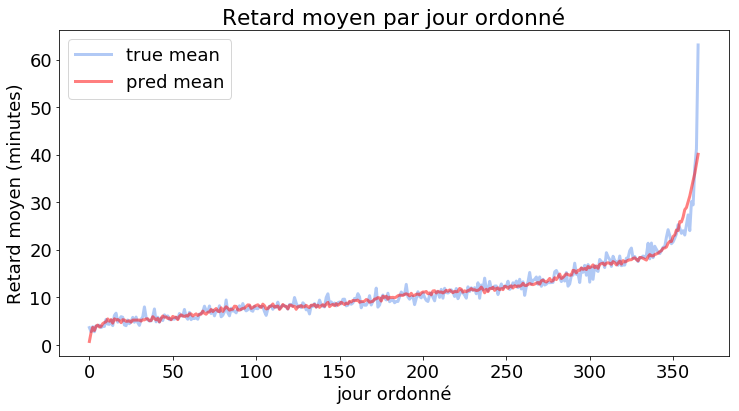

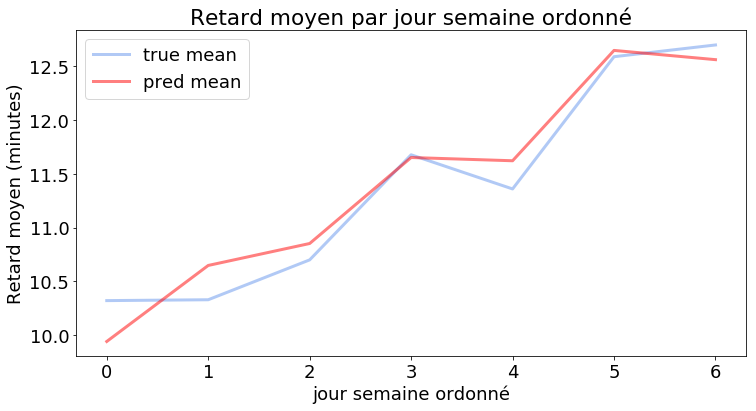

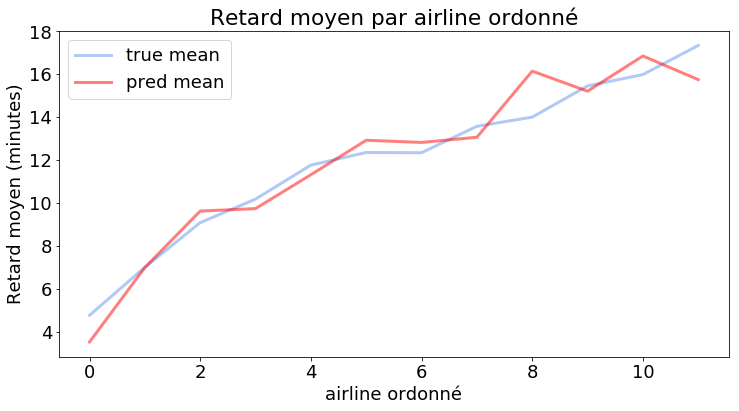

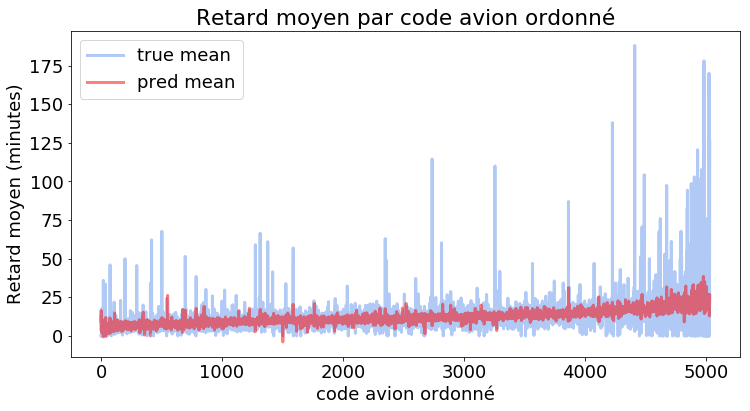

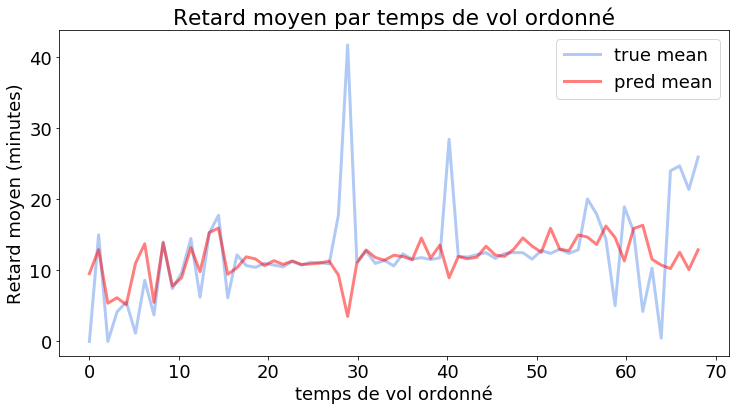

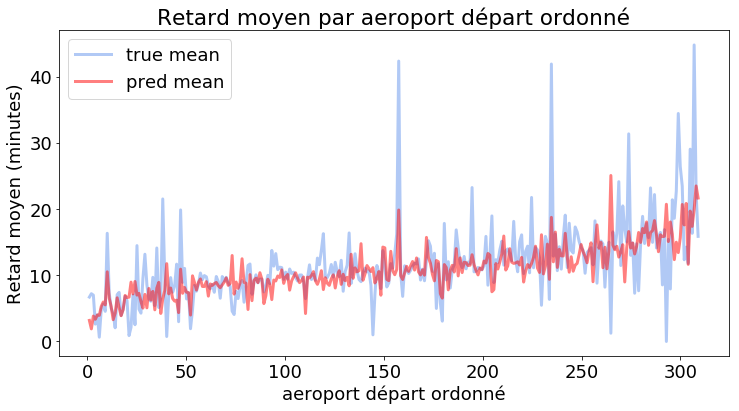

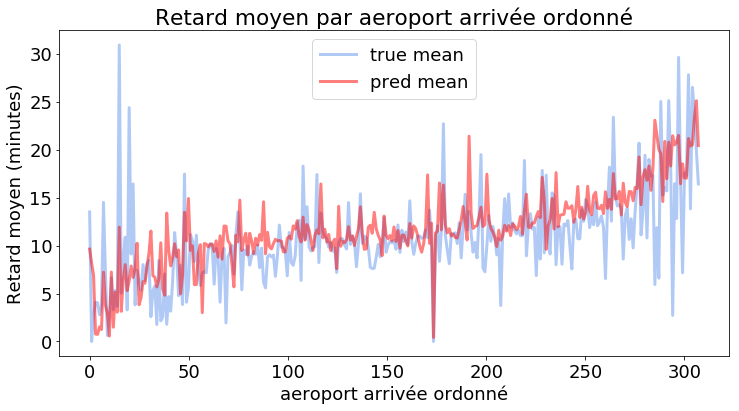

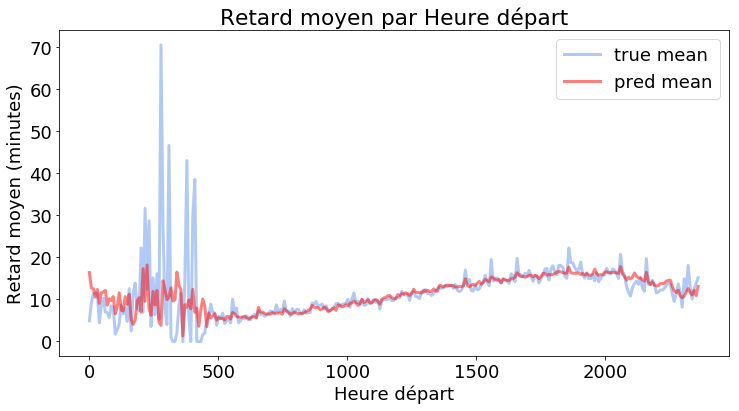

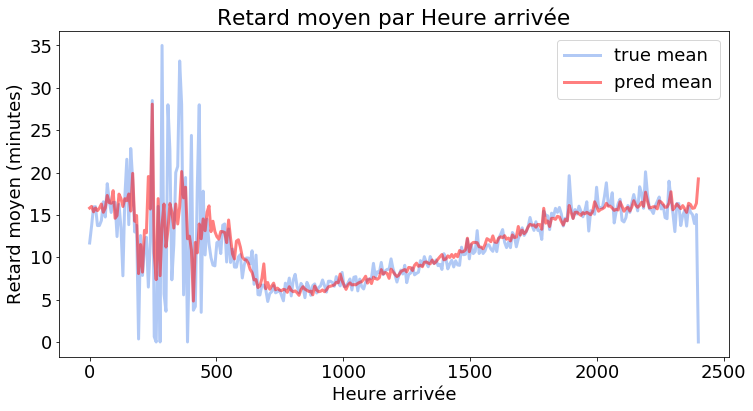

In [259]:
for index, row in X_cols.iterrows():
    col_new_name = row['new_name']
    compare_result_plot(results, col_new_name)
    #compare_result_plot(test_set.loc[X_test.index, [col_new_name]], pd.DataFrame(y_true), pd.DataFrame(y_pred), col_new_name)

## Exporting Data

In [ ]:
generate error on full re run

In [ ]:
ressources_folder = 'flask_api_oc4_xm/ressources/'

### Loading reference tables csv for Airports and Carrier

In [90]:
file_path = 'sources/L_UNIQUE_CARRIERS.csv_'
df_carriers = pd.read_csv(file_path, low_memory=False, index_col = 'Code')

df_carriers = df_carriers.join(test_set.groupby('CARRIER').first()['carrier_ordered']).dropna()
df_carriers.head(2)
df_carriers.to_csv(ressources_folder+'df_carriers.csv')

,Description,carrier_ordered
Code,,
AA,American Airlines Inc.,6.000
AS,Alaska Airlines Inc.,1.000


In [136]:
df_airports

,Description,origin_airport_id_ordered,dest_airport_id_ordered
Code,,,
10135,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",207.000,238.000
10136,"Abilene, TX: Abilene Regional",288.000,229.000
10140,"Albuquerque, NM: Albuquerque International Sun...",121.000,148.000
10141,"Aberdeen, SD: Aberdeen Regional",80.000,50.000
10146,"Albany, GA: Southwest Georgia Regional",178.000,254.000
10154,"Nantucket, MA: Nantucket Memorial",297.000,140.000
10155,"Waco, TX: Waco Regional",217.000,252.000
10157,"Arcata/Eureka, CA: California Redwood Coast Hu...",290.000,290.000
10158,"Atlantic City, NJ: Atlantic City International",283.000,305.000


In [91]:
file_path = 'sources/L_AIRPORT_ID.csv_'
df_airports = pd.read_csv(file_path, low_memory=False, index_col = 'Code')

df_origin_airport = test_set.groupby('ORIGIN_AIRPORT_ID').first()['origin_airport_id_ordered']
df_dest_airport = test_set.groupby('DEST_AIRPORT_ID').first()['dest_airport_id_ordered']
df_airports = df_airports.join(df_origin_airport).join(df_dest_airport).dropna()
df_airports.head(2)
df_airports.shape
df_airports.to_csv(ressources_folder+'df_airports.csv')

,Description,origin_airport_id_ordered,dest_airport_id_ordered
Code,,,
10135,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",207.000,238.000
10136,"Abilene, TX: Abilene Regional",288.000,229.000


(310, 3)

In [132]:
df_day = test_set.groupby('DAY').first()['day_ordered']
df_day.head(2)
df_day.shape
df_day.to_csv(ressources_folder+'df_days.csv')

DAY
1    103
2    149
Name: day_ordered, dtype: int64

(366,)

In [95]:
df_tail_num= test_set.groupby('TAIL_NUM').first()['tail_num_ordered']
df_tail_num.head(2)
df_tail_num.shape
df_tail_num.to_csv(ressources_folder+'df_tail_num.csv')

TAIL_NUM
7819A    1897
7820L    1501
Name: tail_num_ordered, dtype: int64

(5035,)

In [141]:
X_cols.to_csv(ressources_folder+'X_cols.csv', index=False)

## Exporting Model

In [96]:
#s = pickle.dumps(ridge)
joblib.dump(ridge, ressources_folder+'ridge_model.joblib') 

['ridge_model.joblib']

In [97]:
ridge_model = joblib.load(ressources_folder+'ridge_model.joblib') 

In [151]:
ridge_model.predict(X.iloc[[54224]])

array([17.62973918])